# Imports

In [1]:
from catboost import CatBoostClassifier
import emojis as emojis_module
import functools
from imblearn.over_sampling import SMOTE
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet as wn, sentiwordnet as swn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import operator
import os.path
import pandas as pd
import re
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.multiclass import unique_labels
import spacy
import string
import textstat
import time
from tqdm import tqdm
from wordcloud import STOPWORDS, WordCloud

## Tools Initialization

In [2]:
nlp = spacy.load('en_core_web_sm')
porter_stemmer = PorterStemmer()
wn_lemmatizer = WordNetLemmatizer()

In [3]:
def init_emojis_category_dict(restrict_subgroups=True):
    """
    Creates and returns a dictionary containing emojis as keys and their category as values.
    Uses the file 'emoji-test.txt' from Unicode.org available here : https://unicode.org/Public/emoji/12.0/emoji-test.txt.
    """
    subgroups_to_keep = ['face-smiling', 'face-affection', 'face-tongue', 'face-hand', 'face-neutral-skeptical', 'face-concerned', 'monkey-face', 'emotion']
    emojis_dict = {}
    with open('./data/emoji-test.txt', 'r', encoding='utf-8') as emoji_file:
        raw_subgroups = emoji_file.read().split('# subgroup: ')[1:]
        for raw_subgroup in raw_subgroups:
            raw_subgroup = raw_subgroup.split('\n\n')[0]
            raw_subgroup = raw_subgroup.split('\n')
            subgroup_name = raw_subgroup[0]
            if (restrict_subgroups and subgroup_name in subgroups_to_keep) or not restrict_subgroups:
                for entry in raw_subgroup[1:-1]:
                    try:
                        emojis_dict[re.findall(r'^[\W\d]', entry.split('# ')[1])[0]] = subgroup_name
                    except:
                        pass
    return emojis_dict
emojis_category_dict = init_emojis_category_dict()

# Data preprocessing

In [4]:
def read_csv(data_file, separator='\t', header=True, encoding='utf-8'):
    """
    Reads a CSV file then creates and returns a pandas dataframe containing the data. 
    """
    with open(data_file, 'r', encoding=encoding, errors="ignore") as csv_file:
        data = [line.split(separator) for line in csv_file.read().splitlines()]
    data = pd.DataFrame(data[:-1])
    if header:
        header = data.iloc[0]
        data = data[1:]
        data.columns = header
    return data

In [5]:
def load_data():
    """
    Loads the data in a pandas' dataframe and group the tweets by author.
    Returns the dataframe containing following columns : 'doc_id' (int), 'label' (int) and 'content' (str).
    """
    data = pd.DataFrame()
    data_files = ['./data/AMale.txt', './data/AFemale.txt']

    for data_file in data_files:
        data = data.append(read_csv(data_file, separator='\t', header=False, encoding='utf-8'))

    data = data.drop(1, axis='columns') # drop profile's column (human/bot)
    data = data.rename(columns={0: 'doc_id', 2: 'label', 3: 'content'})

    data['doc_id'] = data['doc_id'].apply(lambda x: int(x)) # ids should be integers
    data['label'] = data['label'].apply(lambda gender: 0 if gender == 'M' else 1) # men:0, women:1
    
    # group tweets by author
    data = data.groupby(['doc_id', 'label'])['content'].apply(lambda content_list : " ".join(content_list)).reset_index(name='content')
    
    return data

In [6]:
def preprocess_data(data):
    """
    Applies preprocessing methods on the given dataframe.
    The dataframe must contain following columns :  'doc_id' (int), 'label' (int) and 'content' (str).
    Returns the dataframe.
    """
    # text preprocessing
    data['content'] = data['content'].apply(lambda content: replace_hashtags(replace_mentions(content)))
    
    data['original_content'] = data['content'] # original content shouldn't be changed
    
    data['content'] = data['content'].apply(
        lambda content: stem_sentence(
            re.sub('\s+', ' ', content # remove multiple whitespaces
                #re.sub(r'\b\w{1,3}\b', '', content # remove words of length <= 3
                    .lower() # lower case
                    #.translate(content.maketrans('', '', string.punctuation)) # remove punctuation
    ).strip()))
    
    return data

In [7]:
def stem_sentence(sentence):
    """
    Uses an NLTK Porter stemmer to stem the given text.
    Returns a string.
    """
    return ' '.join([porter_stemmer.stem(word) for word in word_tokenize(sentence)])

In [8]:
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags.
    Code from: https://stackoverflow.com/a/54588366 (post by shantanu pathak, visited the 21.11.2019)
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [9]:
def string_to_nparray_1d(string_array):
    """
    Converts a list of floats written as a string to a numpy array of floats.
    Example : '[1.1, 2.2]' -> [1.1, 2.2]
    Returns a numpy array of floats.
    """
    return np.array([float(value) for value in string_array.replace('[', '').replace(']', '').replace(',', '').split()])

In [10]:
def string_to_nparray_2d(string_array):
    """
    Converts a 2d array written as a string to a list of numpy arrays.
    Example : '[[1.1, 2.2], [3.3, 4.4]]' -> [np.array([1.1, 2.2]), np.array([3.3, 4.4])]
    Returns the list of numpy arrays.
    """
    return np.array([string_to_nparray_1d(array) for array in string_array])

In [11]:
def merge_2d_lists_row_wise(l1, l2):
    """
    Merges row wise two lists of same length.
    Returns the resulting list.
    """
    if len(l1) > 0 and len(l2) > 0:
        #return [[*i, *j] for i, j in zip(l1, l2)]
        return np.concatenate((np.array(l1), np.array(l2)), axis=1).tolist()
    elif len(l1) > 0:
        return l1
    elif len(l2) > 0:
        return l2
    return []

In [12]:
def replace_mentions(text):
    """
    Replaces twitter mentions in the given text by a contant tag.
    Returns the clean text.
    """
    MENTIONS_REPLACEMENT_TAG = "mention"
    MENTIONS_REGEXS = [
        r'(@ [\w\d-]+(( _)|(_ )|( _ )|_)+[\w\d-]+)', # something + _ + something
        r'(@ [\w\d-]+( [\d-]+))', # something + space + numbers
        r'(@ [\w\d-]+)', # something
        ] 

    matches = re.findall('|'.join([f'({regex})' for regex in MENTIONS_REGEXS]), text)
    for tuple_matches in matches:
        if isinstance(tuple_matches, tuple):
            mention = [mention for mention in tuple_matches if len(mention) >= 3][0] # keep the first match which contains at least 3 characters
        else:
            mention = tuple_matches
        text = text.replace(mention, MENTIONS_REPLACEMENT_TAG)
    return text

In [13]:
def replace_hashtags(text):
    """
    Replaces twitter hashtags in the given text by a contant tag.
    Returns the clean text.
    """
    HASHTAGS_REPLACEMENT_TAG = "hashtag"
    HASHTAGS_REGEXS = [
        r'(# [\w\d_-]+( \d+)*)',
        r'(# [\w\d_-]+)',
        ] 

    matches = re.findall('|'.join([f'({regex})' for regex in HASHTAGS_REGEXS]), text)
    for tuple_matches in matches:
        if isinstance(tuple_matches, tuple):
            hashtag = [hashtag for hashtag in tuple_matches if len(hashtag) >= 3][0] # keep the first match which contains at least 3 characters
        else:
            hashtag = tuple_matches
        text = text.replace(hashtag, HASHTAGS_REPLACEMENT_TAG)
    return text

# Dataset statistics

In [14]:
def display_dataset_stats(data, extended=False):
    """
    Displays statistics for 
    - number of words (min/max/avg)
    - number of characters (min/max/avg)
    - number of documents
    - number of documents written by a man/woman
    """
    feature_nb_words = []
    if 'nb_words' not in data.columns:
        for i, row in data.iterrows():
            feature_nb_words.append(compute_row_features(row, {'nb_words' : True})[0][0])
    else:
        feature_nb_words = [vector[0] for vector in data['nb_words'].tolist()]
    print(f'Number of words per document. Average : {sum(feature_nb_words)/len(feature_nb_words)}, Min : {min(feature_nb_words)}, Max : {max(feature_nb_words)}')
    
    if extended:
        feature_nb_words = []
        for i, row in data.loc[data['label'] == 0].iterrows():
            feature_nb_words.append(compute_row_features(row, {'nb_words' : True})[0][0])
        print(f'Number of words per document written by a man. Average : {sum(feature_nb_words)/len(feature_nb_words)}, Min : {min(feature_nb_words)}, Max : {max(feature_nb_words)}')

        feature_nb_words = []
        for i, row in data.loc[data['label'] == 1].iterrows():
            feature_nb_words.append(compute_row_features(row, {'nb_words' : True})[0][0])
        print(f'Number of words per document written by a woman. Average : {sum(feature_nb_words)/len(feature_nb_words)}, Min : {min(feature_nb_words)}, Max : {max(feature_nb_words)}')
    
    feature_nb_characters = []
    if 'nb_characters' not in data.columns:
        for i, row in data.iterrows():
            feature_nb_characters.append(compute_row_features(row, {'nb_characters' : True})[0][0])
    else:
        feature_nb_characters = [vector[0] for vector in data['nb_characters'].tolist()]
    print(f'Number of characters per document. Average : {sum(feature_nb_characters)/len(feature_nb_characters)}, Min : {min(feature_nb_characters)}, Max : {max(feature_nb_characters)}')
     
    if extended:
        feature_nb_characters = []
        for i, row in data.loc[data['label'] == 0].iterrows():
            feature_nb_characters.append(compute_row_features(row, {'nb_characters' : True})[0][0])
        print(f'Number of characters per document written by a man. Average : {sum(feature_nb_characters)/len(feature_nb_characters)}, Min : {min(feature_nb_characters)}, Max : {max(feature_nb_characters)}')

        feature_nb_characters = []
        for i, row in data.loc[data['label'] == 1].iterrows():
            feature_nb_characters.append(compute_row_features(row, {'nb_characters' : True})[0][0])
        print(f'Number of characters per document written by a woman. Average : {sum(feature_nb_characters)/len(feature_nb_characters)}, Min : {min(feature_nb_characters)}, Max : {max(feature_nb_characters)}')
    
    print(f'Number of documents written by a man : {len([x for x in data["label"] if x == 0])}')
    print(f'Number of documents written by a woman : {len([x for x in data["label"] if x == 1])}')   

# Features

In [15]:
def compute_feature_nb_characters(row):
    """
    Computes the feature nb_character for the given row.
    Return the feature and its length.
    """
    return len(row['content']), 1

In [16]:
def compute_feature_nb_words(row):
    """
    Computes the feature nb_words for the given row.
    Return the feature and its length.
    """
    doc = nlp(row['content'])
    return len(doc), 1

In [17]:
def compute_feature_nb_nouns(row):
    """
    Computes the feature nb_nouns for the given row.
    Return the feature and its length.
    """
    doc = nlp(row['content'])
    return len([token for token in doc if token.pos_ == "NOUN"]), 1

In [18]:
def compute_feature_nb_pronouns(row):
    """
    Computes the feature nb_pronouns for the given row.
    Return the feature and its length.
    """
    doc = nlp(row['content'])
    return len([token for token in doc if token.pos_ == "PRON"]), 1

In [19]:
def compute_feature_nb_digits(row):
    """
    Computes the feature nb_digits for the given row.
    Return the feature and its length.
    """
    return sum(c.isdigit() for c in row['content']), 1

In [20]:
def compute_feature_flesch_readibility(row):
    """
    Computes the feature flesch_readibility for the given row.
    Return the feature and its length.
    """
    return textstat.flesch_reading_ease(row['content']), 1

In [21]:
def compute_feature_nb_emojis(row):
    """
    Computes the feature nb_emojis for the given row.
    Return the feature and its length.
    """
    return emojis_module.count(row['content']), 1

In [22]:
def compute_feature_nb_emojis_per_cat(row):
    """
    Computes the feature nb_emojis_per_cat for the given row.
    Return the feature and its length.
    """
    feature = dict(zip(set(emojis_category_dict.values()), [0 for _ in range(len(set(emojis_category_dict.values())))]))
    for char in emojis_module.get(row['content']):
        if char in emojis_category_dict:
            feature[emojis_category_dict[char]] += row['content'].count(char)
    return list(feature.values()), len(feature.values())

In [23]:
def compute_feature_nb_mentions(row):
    """
    Computes the feature nb_mentions for the given row.
    Return the feature and its length.
    """
    return row['content'].count('mention'), 1

In [24]:
def compute_feature_nb_hashtags(row):
    """
    Computes the feature nb_hashtags for the given row.
    Return the feature and its length.
    """
    return row['content'].count('hashtag'), 1

In [25]:
def compute_feature_nb_urls(row):
    """
    Computes the feature nb_urls for the given row.
    Return the feature and its length.
    """
    return row['content'].count('urllink'), 1

In [26]:
def compute_feature_nb_rts(row):
    """
    Computes the feature nb_rts for the given row.
    Return the feature and its length.
    """
    return row['content'].count('rt'), 1

In [27]:
def compute_feature_nb_big_words(row):
    """
    Computes the feature nb_big_words for the given row.
    Return the feature and its length.
    """
    simple_words_regex = r'\w+'
    long_words_regex = r'^[a-z-]{6,}$'
    long_words = [re.search(long_words_regex, word).group(0) 
                    for word in re.findall(simple_words_regex, row['content']) 
                    if re.search(long_words_regex, word)]
    return len(long_words), 1

In [28]:
def compute_feature_positivity_measure(row):
    """
    Computes the feature positivity_measure for the given row.
    Return the feature and its length.
    Code adapted from: https://stackoverflow.com/a/54588366 (post by shantanu pathak, visited the 21.11.2019)
    """
    positivity_measure = 0
    
    words = nltk.word_tokenize(nltk.sent_tokenize(row['original_content'])[0])
    words = [porter_stemmer.stem(word) for word in words]

    for word, tag in nltk.pos_tag(words):
        wn_tag = penn_to_wn(tag)
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
            continue

        lemma = wn_lemmatizer.lemmatize(word, pos=wn_tag)
        if not lemma:
            continue

        synsets = wn.synsets(word, pos=wn_tag)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())

        pos_score = swn_synset.pos_score()
        neg_score = swn_synset.neg_score()
        #obj_score = swn_synset.obj_score()
        #polarity = 0 if obj_score > pos_score and obj_score > neg_score else pos_score - neg_score
        positivity_measure += pos_score - neg_score
    positivity_measure /= len(words)

    return positivity_measure, 1

In [71]:
def compute_feature_tfidf(training_data, test_data):
    """
    Computes the feature tfidf for the given train and test data..
    Return a list of feature's vectors and the length of a vector.
    """
    vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2), stop_words='english', min_df=10, max_df=0.8, max_features=2500)
    X_train = vectorizer.fit_transform(training_data['content'].tolist()).toarray()
    X_test = vectorizer.transform(test_data['content'].tolist()).toarray()
    
    features = {index: vector for index, vector in list(zip(training_data.index, X_train)) + list(zip(test_data.index, X_test))}
    features = [vector for _, vector in sorted(features.items())]
    return features, len(features[0]), ['tf-idf: ' + feature_name for feature_name in vectorizer.get_feature_names()]

In [30]:
def compute_row_features(row, features_dict):
    """
    Computes the features specified in the given dictionary for the given row.
    Returns a list of new features and a list of their respective length.
    """
    features = []
    features_length = []
    for feature_name, is_feature_used in features_dict.items():
        if is_feature_used:
            if feature_name == 'nb_characters':
                new_feature, new_feature_length = compute_feature_nb_characters(row)
            elif feature_name == 'nb_words':
                new_feature, new_feature_length = compute_feature_nb_words(row)
            elif feature_name == 'nb_nouns':
                new_feature, new_feature_length = compute_feature_nb_nouns(row)
            elif feature_name == 'nb_pronouns':
                new_feature, new_feature_length = compute_feature_nb_pronouns(row)
            elif feature_name == 'nb_digits':
                new_feature, new_feature_length = compute_feature_nb_digits(row)
            elif feature_name == 'flesch_readibility':
                new_feature, new_feature_length = compute_feature_flesch_readibility(row)
            elif feature_name == 'nb_emojis':
                new_feature, new_feature_length = compute_feature_nb_emojis(row)
            elif feature_name == 'nb_emojis_per_cat':
                new_feature, new_feature_length = compute_feature_nb_emojis_per_cat(row)
            elif feature_name == 'nb_mentions':
                new_feature, new_feature_length = compute_feature_nb_mentions(row)
            elif feature_name == 'nb_hashtags':
                new_feature, new_feature_length = compute_feature_nb_hashtags(row)
            elif feature_name == 'nb_urls':
                new_feature, new_feature_length = compute_feature_nb_urls(row)
            elif feature_name == 'nb_rts':
                new_feature, new_feature_length = compute_feature_nb_rts(row)
            elif feature_name == 'nb_big_words':
                new_feature, new_feature_length = compute_feature_nb_big_words(row)
            elif feature_name == 'positivity_measure':
                new_feature, new_feature_length = compute_feature_positivity_measure(row)
                
            else:
                continue
            if isinstance(new_feature, list):
                features = [*features, *new_feature]
            else:
                features.append(new_feature)
            features_length.append(new_feature_length)
    return features, features_length

In [64]:
def compute_complex_features(data, features_dict, train_indices, test_indices, SPECIAL_FEATURES_NAME):
    """
    Computes the complex features specified in the given dictionary for the whole dataframe.
    Returns a 2d list containing the new features and a list of their respective length.
    """    
    # identify train and test data
    training_data = data.iloc[train_indices, :]
    test_data = data.iloc[test_indices, :]
    
    # for each complex feature
    features = []
    features_length = []
    features_components_name = []
    for feature_name, is_feature_used in features_dict.items():
        if is_feature_used: 
            if feature_name == 'tfidf':
                new_feature, new_feature_length, new_feature_components_name = compute_feature_tfidf(training_data, test_data)
            else:
                continue
            
            # append the new vectors to the other features (row by row)
            features = merge_2d_lists_row_wise(features, new_feature)
            features_length.append(new_feature_length)
            SPECIAL_FEATURES_NAME[feature_name] = new_feature_components_name
    return features, features_length

In [66]:
def compute_dataframe_features(data, features_dict, train_indices, test_indices, STATIC_BASIC_FEATURES_LIST, STATIC_COMPLEX_FEATURES_LIST, SPECIAL_FEATURES_NAME):
    """
    Computes the features specified in the given dictionary for the whole dataframe.
    Returns the dataframe containing the computed features.
    """
    all_new_features, all_new_features_name = [], []
    features_length, complex_features_length = [], []
    basic_features_dict = set(STATIC_BASIC_FEATURES_LIST).intersection(set(features_dict.keys()))
    basic_features_dict = {feature_name: features_dict[feature_name] for feature_name in basic_features_dict}
    complex_features_dict = set(STATIC_COMPLEX_FEATURES_LIST).intersection(set(features_dict.keys()))
    complex_features_dict = {feature_name: features_dict[feature_name] for feature_name in complex_features_dict}

    # compute basic features (row by row)
    for i, row in data.iterrows():
        computed_features, features_length = compute_row_features(row, basic_features_dict)
        all_new_features.append(computed_features)
    
    # compute complex features (for the whole dataframe)
    complex_computed_features, complex_features_length = compute_complex_features(data, complex_features_dict, train_indices, test_indices, SPECIAL_FEATURES_NAME)
    
    # merge basic features and complex features
    all_new_features = merge_2d_lists_row_wise(all_new_features, complex_computed_features)
    features_length = features_length + complex_features_length
    
    # save features name in the dataframe
    computed_features_list = [feature_name for feature_name, is_feature_used in list(basic_features_dict.items()) + list(complex_features_dict.items()) if is_feature_used]
    for f_id, feature_name in enumerate(computed_features_list):
        if feature_name not in SPECIAL_FEATURES_NAME.keys():
            for v_id in range(features_length[f_id]):
                all_new_features_name.append(f'{feature_name}_{v_id}' if features_length[f_id] > 1 else feature_name)
        elif isinstance(SPECIAL_FEATURES_NAME[feature_name], list):
            all_new_features_name = [*all_new_features_name, *SPECIAL_FEATURES_NAME[feature_name]]
        else:
            all_new_features_name.append(SPECIAL_FEATURES_NAME[feature_name])
    if 'features_name' in data:
        data['features_name'] = [[*data.iloc[0]['features_name'], *all_new_features_name] for _ in data.index]
    else:
        data['features_name'] = [all_new_features_name for _ in data.index]
        
    # save features in the dataframe
    if 'features' in data:
        previous_features = string_to_nparray_2d(data['features'].tolist()).tolist() if isinstance(data['features'][0], str) else data['features'].tolist()
        data['features'] = merge_2d_lists_row_wise(previous_features, all_new_features)
    else:
        data['features'] = all_new_features
    
    # create each feature's own column in the dataframe
    all_new_features = np.swapaxes(np.array(all_new_features), 0, 1)
    i = 0
    for feature_name, is_feature_used in list(basic_features_dict.items()) + list(complex_features_dict.items()):
        if is_feature_used and feature_name not in data: # if feature is used and not already in the dataframe: add its column
            prev = sum(features_length[:i])
            data[feature_name] = list(zip(*all_new_features[prev : prev+features_length[i], ::]))
            i += 1
    return data

In [33]:
def compute_features(data, features, train_indices, test_indices, scaler, STATIC_BASIC_FEATURES_LIST, STATIC_COMPLEX_FEATURES_LIST, SPECIAL_FEATURES_NAME):
    """
    Computes the features listed in the 'features' dictionary for the given dataframe. 
    Scales the resulting vectors if a scaler has been specified.
    Returns the dataframe, X_train, y_train, X_test, y_test
    """
    data = compute_dataframe_features(data, features, train_indices, test_indices, STATIC_BASIC_FEATURES_LIST, STATIC_COMPLEX_FEATURES_LIST, SPECIAL_FEATURES_NAME)
    
    X_train = np.array(data.iloc[train_indices, :]['features'].tolist())
    y_train = np.array(data.iloc[train_indices, :]['label'].tolist())
    X_test = np.array(data.iloc[test_indices, :]['features'].tolist())
    y_test = np.array(data.iloc[test_indices, :]['label'].tolist())
    
    # scale data
    if scaler is not None:
        X_train, X_test = scale_data(scaler, X_train, X_test)
        
        scaled_features_col = {index: vector for index, vector in list(zip(train_indices, X_train)) + list(zip(test_indices, X_test))}
        scaled_features_col = [vector for _, vector in sorted(scaled_features_col.items())]
        data = data.assign(scaled_features=pd.Series(scaled_features_col))
        
    return data, X_train, y_train, X_test, y_test

In [34]:
def scale_data(scaler, X_train, X_test):
    """
    Uses a Scikit-Learn scaler to scale the data.
    Returns the scaled X_train and X_test.
    """
    scaler = scaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

# Classification

In [35]:
def train_model(classifier, X_train, y_train, X_test, y_test, params, confusion_matrix=True):
    """
    Initializes an instance of the given classification model with its parameters.
    Trains and evaluates the classifier before returning it with the classification scores.
    """
    model = classifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = [accuracy_score(y_test, y_pred), 
              precision_score(y_test, y_pred, average=None), 
              recall_score(y_test, y_pred, average=None)]
    if confusion_matrix:
        plot_confusion_matrix(y_test, y_pred, np.array(['Man', 'Woman']), normalize=True)
    return model, scores

In [36]:
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Data visualization & feature selection

In [37]:
def plot_data(X_train, y_train, X_test, y_test):
    """
    Uses t-SNE to plot an approximation of the data projected in 2d.
    """
    X_embedded = TSNE(n_components=2).fit_transform(np.concatenate((X_train, X_test)))
    
    category_to_color = {0: 'blue', 1: 'magenta'}
    category_to_label_train = {0: 'Man (training set)', 1: 'Woman (training set)'}
    category_to_label_test = {0: 'Man (test set)', 1: 'Woman (test set)'}
    
    plt.figure(figsize=(10,10))
    for category in category_to_color.keys():
        plt_x_train = [X_embedded[i,0] for i, cat in enumerate(y_train) if cat == category]
        plt_y_train = [X_embedded[i,1] for i, cat in enumerate(y_train) if cat == category]
        
        offset_train = len(X_train)
        plt_x_test = [X_embedded[offset_train+i,0] for i, cat in enumerate(y_test) if cat == category]
        plt_y_test = [X_embedded[offset_train+i,1] for i, cat in enumerate(y_test) if cat == category]
        
        plt.scatter(plt_x_train, plt_y_train, marker='.', color=category_to_color[category], label=category_to_label_train[category], alpha=0.6)
        plt.scatter(plt_x_test, plt_y_test, marker='x', color=category_to_color[category], label=category_to_label_test[category], alpha=0.6)
        plt.legend(loc='best')
    plt.title('Corpus entries\' visualization')
    plt.show()

In [38]:
def plot_wordcloud(text, colormap, collocations=False):
    """
    Plots a wordcloud for the given text.
    """
    stopwords = set(STOPWORDS)
    stopwords.update(['hashtag', 'mention', 'urllink', 'rt'])
    wordcloud = WordCloud(stopwords=stopwords, collocations=collocations, 
                          background_color="white", colormap=colormap, 
                          width=1920, height=1080)
    wordcloud = wordcloud.generate(text)
    plt.figure(num=None, figsize=(9, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
    plt.axis("off")
    plt.show()

In [39]:
def features_selection(data, target, features):
    """
    Uses shap and CatBoost for features selection. Plots results.
    """
    X = np.array(data)
    y = np.array(target)
    #model = RandomForestClassifier(n_jobs=2, random_state=42).fit(X, y)
    model = CatBoostClassifier(iterations=125, allow_writing_files=False, verbose=0)
    model.fit(X, y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, feature_names=features, plot_type='bar')
    shap.summary_plot(shap_values, X, feature_names=features)

# Constants

In [72]:
# define constants here...

# data
LOAD_DATA_FROM_CSV = True
RECOMPUTE_FEATURES = True
SAVE_AFTER_RECOMPUTING_FEATURES = False
DATA_PKL_FILE = './data/basic_7_standardsc_20.pkl'

# features
FEATURES = {
    'nb_characters':      True, # (paper 2)
    'nb_words':           True, # (paper 2)
    'nb_nouns':           True, # (paper 2)
    'nb_pronouns':        True, # (paper 2)
    'nb_digits':          True, # (paper 2)
    'flesch_readibility': True, # (paper 2)
    'nb_emojis':          True, # (paper 2)
    'nb_emojis_per_cat':  True, # (paper 2)
    
    'nb_mentions':        True, # (paper 5)
    'nb_hashtags':        True, # (paper 5)
    'nb_urls':            True, # (paper 5)
    'nb_rts':             True, # (paper 5)
    
    'nb_big_words':       True, # (custom)
    'positivity_measure': True, # (custom)
    
    'tfidf':              True, # (paper 3)
}

# models
CLASSIFIER = CatBoostClassifier # [CatBoostClassifier, RandomForestClassifier, LinearSVC]
SCALER = RobustScaler # [None, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler]

# models' parameters
PARAMS = {
    CatBoostClassifier: {
        'iterations':200, 
        'depth':6, 
        'learning_rate':0.2, 
        'loss_function':'CrossEntropy', 
        'custom_metric':['Accuracy', 'Recall', 'Precision'], 
        'verbose':False
    },
    RandomForestClassifier: {
        'bootstrap':True, 
        'class_weight':None, 
        'criterion':'gini',
        'max_depth':None, 
        'max_features':'auto', 
        'max_leaf_nodes':None,
        'min_samples_leaf':1,
        'min_samples_split':2, 
        'min_weight_fraction_leaf':0.0,
        'n_estimators':10, 
        'oob_score':False, 
        'warm_start':False,
        'verbose':0, 
    },
    LinearSVC: {
        
    },
}
GRIDSEARCH_PARAMS_RANGE = {
    CatBoostClassifier: {
        'loss_function': ['Logloss', 'CrossEntropy'],
        'iterations': [250,100,500,1000],
        'depth': [3,1,2,6,4,5,7,8,9,10],
        'learning_rate': [0.03,0.001,0.01,0.1,0.2,0.3], 
    },
    RandomForestClassifier: {
        
    },
    LinearSVC: {
        
    },
}

# training
GRIDSEARCH_NB_CV_SPLITS = 2
TEST_SIZE = 0.20

# ---- constants' validity check
DATA_CSV_STATIC_COLUMNS = ['doc_id', 'label', 'content', 'original_content', 'train_entry', 'features']
STATIC_BASIC_FEATURES_LIST = [
    'nb_characters', 'nb_words', 'nb_nouns', 'nb_pronouns', 'nb_digits', 'nb_mentions', 'nb_hashtags', 'nb_urls', 'nb_rts', 
    'nb_emojis', 'nb_emojis_per_cat', 'nb_big_words', 'positivity_measure', 'nb_lexical_words', 'flesch_readibility']
STATIC_COMPLEX_FEATURES_LIST = ['tfidf']
SPECIAL_FEATURES_NAME = {'nb_emojis_per_cat': [f'emojis: {emoji_cat}' for emoji_cat in list(set(emojis_category_dict.values()))]}
assert all([feature in STATIC_BASIC_FEATURES_LIST+STATIC_COMPLEX_FEATURES_LIST for feature in FEATURES.keys()])
assert GRIDSEARCH_NB_CV_SPLITS > 1
assert CLASSIFIER in [CatBoostClassifier, RandomForestClassifier, LinearSVC]
assert SCALER in [None, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler]
assert TEST_SIZE > 0.0 and TEST_SIZE < 1.0

# Main

In [73]:
# load the data
if LOAD_DATA_FROM_CSV and os.path.isfile(DATA_PKL_FILE):
    data = pd.read_pickle(DATA_PKL_FILE)
    features_column = 'scaled_features' if 'scaled_features' in data else 'features'
    train_entries = data.loc[data['train_entry'] == 1]
    test_entries = data.loc[data['train_entry'] == 0]
    features_name = data.iloc[0]['features_name']
    X_train = train_entries[features_column].tolist()
    y_train = train_entries['label'].tolist()
    X_test = test_entries[features_column].tolist()
    y_test = test_entries['label'].tolist()
    
else:
    if LOAD_DATA_FROM_CSV:
        print(f'Can\'t load data from CSV. File does not exist: {DATA_CSV_FILE}\nCreating dataset...')
    data = load_data()
    data = preprocess_data(data)
    
    # split train/test sets
    train_indices, test_indices = next(StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE).split(data, np.array(data['label'].tolist())))
    data['train_entry'] = [1 if i in train_indices else 0 for i in data.index] # train:1, test:0

    # compute features
    data, X_train, y_train, X_test, y_test = compute_features(data, FEATURES, train_indices, test_indices, SCALER, STATIC_BASIC_FEATURES_LIST, STATIC_COMPLEX_FEATURES_LIST, SPECIAL_FEATURES_NAME)
    features_name = data.iloc[0]['features_name']

    # export the dataset as CSV
    data.to_pickle(DATA_PKL_FILE)
print('Dataset loaded!')

Dataset loaded!


In [74]:
# compute more features
if LOAD_DATA_FROM_CSV and os.path.isfile(DATA_PKL_FILE) and RECOMPUTE_FEATURES:
    precomputed_features_name = [col_name for col_name in data.columns if col_name not in DATA_CSV_STATIC_COLUMNS]
    features_to_compute = {feature_name: is_feature_used for feature_name, is_feature_used in FEATURES.items() 
                           if feature_name not in precomputed_features_name and is_feature_used}

    train_indices = [i for i in data.index if data.iloc[i, :]['train_entry'] == 1]
    test_indices = [i for i in data.index if data.iloc[i, :]['train_entry'] == 0]
    data, X_train, y_train, X_test, y_test = compute_features(data, features_to_compute, train_indices, test_indices, SCALER, STATIC_BASIC_FEATURES_LIST, STATIC_COMPLEX_FEATURES_LIST, SPECIAL_FEATURES_NAME)
    features_name = data.iloc[0]['features_name']

    # export the dataset as CSV
    if SAVE_AFTER_RECOMPUTING_FEATURES:
        data.to_pickle(DATA_PKL_FILE)
    
    print(f'New features computed: {list(features_to_compute.keys())}.')

New features computed: ['nb_mentions', 'nb_hashtags', 'nb_urls', 'nb_rts', 'nb_big_words', 'positivity_measure', 'tfidf'].


In [75]:
# display dataset info
display_dataset_stats(data, extended=False)
print('Shape of the dataframe :', data.shape)
print('Number of train entries :', len(data.loc[data['train_entry'] == 1].index))
print('Number of test entries :', len(data.loc[data['train_entry'] == 0].index))
print('Size of the features\' vectors :', len(string_to_nparray_1d(data.iloc[0,:]['features'])) if isinstance(data.iloc[0,:]['features'], str) else len(data.iloc[0,:]['features']))
data.head()

Number of words per document. Average : 1948.8043689320389, Min : 649.0, Max : 3881.0
Number of characters per document. Average : 8969.525242718446, Min : 3010.0, Max : 19215.0
Number of documents written by a man : 1030
Number of documents written by a woman : 1030
Shape of the dataframe : (2060, 23)
Number of train entries : 1339
Number of test entries : 721
Size of the features' vectors : 2521


,doc_id,label,content,original_content,train_entry,features_name,features,nb_digits,nb_emojis_per_cat,nb_words,...,nb_emojis,nb_pronouns,scaled_features,nb_hashtags,nb_big_words,nb_rts,positivity_measure,nb_mentions,nb_urls,tfidf
0,0,1,alex is too nice for love island : ( rt mentio...,alex is too nice for love island :( rt mentio...,1,"[nb_digits, emojis: face-hand, emojis: face-sm...","[27.0, 0.0, 23.0, 3.0, 19.0, 0.0, 0.0, 0.0, 4....","(27.0,)","(0.0, 23.0, 3.0, 19.0, 0.0, 0.0, 0.0, 4.0)","(1387.0,)",...,"(56.0,)","(79.0,)","[-0.5833333333333334, 0.0, 3.142857142857143, ...","(3.0,)","(228.0,)","(37.0,)","(0.04310344827586207,)","(80.0,)","(23.0,)","(0.0, 0.0, 0.04573715117094553, 0.0, 0.0, 0.0,..."
1,1,1,rt mention : the crypto financ ecosystem by me...,rt mention : the crypto finance ecosystem by m...,1,"[nb_digits, emojis: face-hand, emojis: face-sm...","[70.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(70.0,)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(2250.0,)",...,"(1.0,)","(103.0,)","[0.6111111111111112, 0.0, -0.14285714285714285...","(68.0,)","(569.0,)","(90.0,)","(-0.02364864864864865,)","(128.0,)","(56.0,)","(0.0, 0.023952279359350976, 0.0485951600062114..."
2,5,1,mention mention ! ! ! ! ! mention mention x i ...,mention mention !!!!! mention mention x i fu...,1,"[nb_digits, emojis: face-hand, emojis: face-sm...","[39.0, 0.0, 26.0, 6.0, 14.0, 0.0, 3.0, 1.0, 7....","(39.0,)","(0.0, 26.0, 6.0, 14.0, 0.0, 3.0, 1.0, 7.0)","(1273.0,)",...,"(73.0,)","(78.0,)","[-0.25, 0.0, 3.5714285714285716, 6.0, 7.0, 0.0...","(1.0,)","(232.0,)","(29.0,)","(0.0,)","(116.0,)","(18.0,)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.02408134144614719,..."
3,6,0,mention ahaha last time act reckless 😂😂 mentio...,mention ahaha last time acting reckless 😂😂 me...,0,"[nb_digits, emojis: face-hand, emojis: face-sm...","[15.0, 0.0, 164.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0....","(15.0,)","(0.0, 164.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1102.0,)",...,"(191.0,)","(77.0,)","[-0.9166666666666666, 0.0, 23.285714285714285,...","(0.0,)","(191.0,)","(12.0,)","(-0.011111111111111112,)","(70.0,)","(32.0,)","(0.0, 0.0, 0.040615244006835215, 0.04582142733..."
4,8,1,i ' m so excit for the boojum i ' m about to g...,i ' m so excited for the boojum i ' m about to...,1,"[nb_digits, emojis: face-hand, emojis: face-sm...","[27.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 13.0...","(27.0,)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 13.0)","(1714.0,)",...,"(16.0,)","(203.0,)","[-0.5833333333333334, 0.0, -0.1428571428571428...","(1.0,)","(239.0,)","(32.0,)","(0.0024834437086092716,)","(54.0,)","(24.0,)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


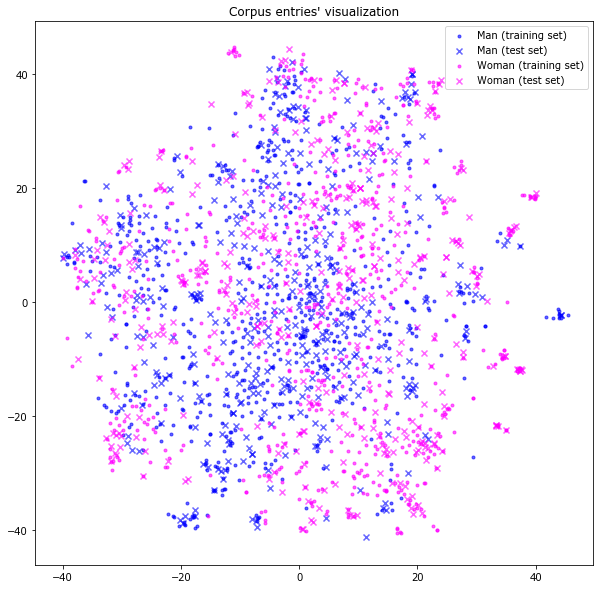

In [76]:
# t-SNE
plot_data(X_train, y_train, X_test, y_test)

Men's tweets :


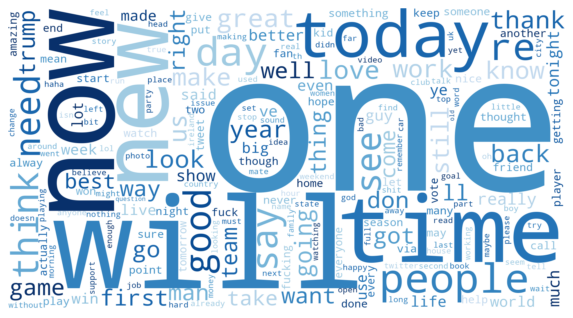

Women's tweets :


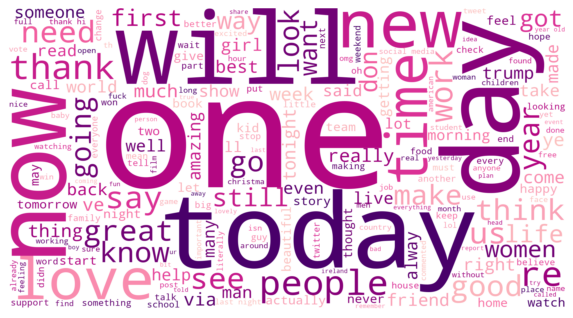

In [43]:
# wordcloud
print('Men\'s tweets :')
men_cmap = mpl.colors.ListedColormap(mpl.cm.Blues(np.linspace(0, 1, 20))[5:,:-1])
plot_wordcloud(' '.join(list(data.loc[data['label'] == 0]['original_content'])), men_cmap, collocations=True)
print('Women\'s tweets :')
women_cmap = mpl.colors.ListedColormap(mpl.cm.RdPu(np.linspace(0, 1, 20))[5:,:-1])
plot_wordcloud(' '.join(list(data.loc[data['label'] == 1]['original_content'])), women_cmap, collocations=True)

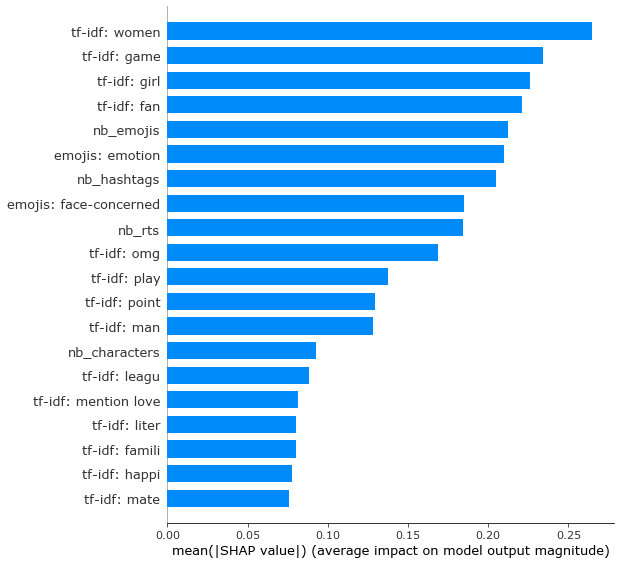

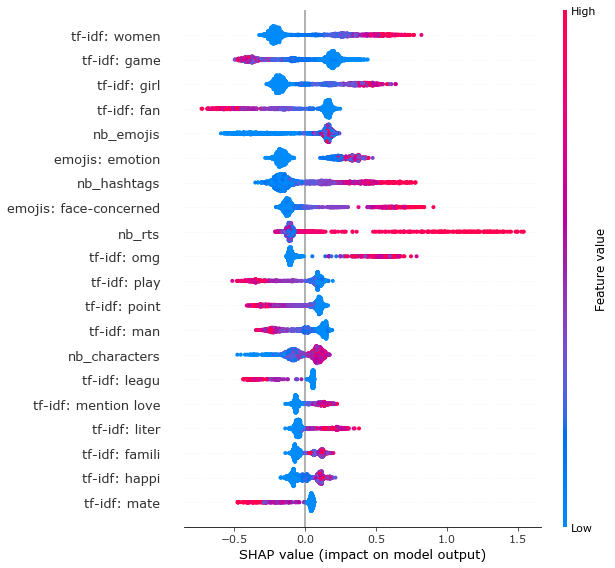

In [77]:
# feature selection
features_selection(np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test)), features_name)

In [61]:
# gridsearch
clf = GridSearchCV(CLASSIFIER(), GRIDSEARCH_PARAMS_RANGE[CLASSIFIER], cv=GRIDSEARCH_NB_CV_SPLITS)
clf.fit(X_train, y_train)
print(f'Best classification score: {clf.best_score_}')
print(f'Best parameters: {clf.best_params_}')

0:	learn: 0.6898758	total: 19.9ms	remaining: 4.96s
1:	learn: 0.6861127	total: 34.8ms	remaining: 4.31s
2:	learn: 0.6821211	total: 49.4ms	remaining: 4.07s
3:	learn: 0.6789173	total: 59.2ms	remaining: 3.64s
4:	learn: 0.6760403	total: 71.3ms	remaining: 3.5s
5:	learn: 0.6718466	total: 85.6ms	remaining: 3.48s
6:	learn: 0.6692781	total: 96.1ms	remaining: 3.33s
7:	learn: 0.6652595	total: 107ms	remaining: 3.24s
8:	learn: 0.6616967	total: 121ms	remaining: 3.25s
9:	learn: 0.6582990	total: 131ms	remaining: 3.15s
10:	learn: 0.6559392	total: 141ms	remaining: 3.07s
11:	learn: 0.6526393	total: 157ms	remaining: 3.11s
12:	learn: 0.6490381	total: 167ms	remaining: 3.04s
13:	learn: 0.6455555	total: 177ms	remaining: 2.99s
14:	learn: 0.6433925	total: 195ms	remaining: 3.05s
15:	learn: 0.6397214	total: 206ms	remaining: 3.01s
16:	learn: 0.6368268	total: 217ms	remaining: 2.98s
17:	learn: 0.6348207	total: 228ms	remaining: 2.94s
18:	learn: 0.6324252	total: 240ms	remaining: 2.91s
19:	learn: 0.6300337	total: 253ms	r

161:	learn: 0.4770864	total: 1.93s	remaining: 1.05s
162:	learn: 0.4763872	total: 1.94s	remaining: 1.03s
163:	learn: 0.4760577	total: 1.95s	remaining: 1.02s
164:	learn: 0.4756142	total: 1.96s	remaining: 1.01s
165:	learn: 0.4742981	total: 1.97s	remaining: 998ms
166:	learn: 0.4737710	total: 1.99s	remaining: 988ms
167:	learn: 0.4730351	total: 2s	remaining: 977ms
168:	learn: 0.4728402	total: 2.01s	remaining: 966ms
169:	learn: 0.4722368	total: 2.03s	remaining: 955ms
170:	learn: 0.4714202	total: 2.04s	remaining: 944ms
171:	learn: 0.4707585	total: 2.05s	remaining: 932ms
172:	learn: 0.4695223	total: 2.07s	remaining: 920ms
173:	learn: 0.4690093	total: 2.08s	remaining: 908ms
174:	learn: 0.4686144	total: 2.09s	remaining: 898ms
175:	learn: 0.4681319	total: 2.1s	remaining: 885ms
176:	learn: 0.4680671	total: 2.12s	remaining: 873ms
177:	learn: 0.4676609	total: 2.13s	remaining: 863ms
178:	learn: 0.4671203	total: 2.15s	remaining: 851ms
179:	learn: 0.4665347	total: 2.16s	remaining: 839ms
180:	learn: 0.46

71:	learn: 0.5394862	total: 878ms	remaining: 2.17s
72:	learn: 0.5379539	total: 889ms	remaining: 2.16s
73:	learn: 0.5373300	total: 901ms	remaining: 2.14s
74:	learn: 0.5361168	total: 920ms	remaining: 2.15s
75:	learn: 0.5347902	total: 931ms	remaining: 2.13s
76:	learn: 0.5336605	total: 943ms	remaining: 2.12s
77:	learn: 0.5327731	total: 960ms	remaining: 2.12s
78:	learn: 0.5318075	total: 973ms	remaining: 2.11s
79:	learn: 0.5307684	total: 990ms	remaining: 2.1s
80:	learn: 0.5293025	total: 1s	remaining: 2.09s
81:	learn: 0.5285730	total: 1.01s	remaining: 2.08s
82:	learn: 0.5275377	total: 1.02s	remaining: 2.06s
83:	learn: 0.5266902	total: 1.03s	remaining: 2.05s
84:	learn: 0.5255579	total: 1.05s	remaining: 2.03s
85:	learn: 0.5245310	total: 1.06s	remaining: 2.02s
86:	learn: 0.5236623	total: 1.07s	remaining: 2.01s
87:	learn: 0.5228313	total: 1.09s	remaining: 2s
88:	learn: 0.5218913	total: 1.1s	remaining: 1.99s
89:	learn: 0.5211743	total: 1.11s	remaining: 1.98s
90:	learn: 0.5196461	total: 1.13s	remai

230:	learn: 0.4271512	total: 2.86s	remaining: 235ms
231:	learn: 0.4265258	total: 2.87s	remaining: 223ms
232:	learn: 0.4258839	total: 2.89s	remaining: 211ms
233:	learn: 0.4251940	total: 2.9s	remaining: 198ms
234:	learn: 0.4242325	total: 2.92s	remaining: 186ms
235:	learn: 0.4238454	total: 2.93s	remaining: 174ms
236:	learn: 0.4235178	total: 2.94s	remaining: 161ms
237:	learn: 0.4229349	total: 2.95s	remaining: 149ms
238:	learn: 0.4219259	total: 2.97s	remaining: 137ms
239:	learn: 0.4214815	total: 2.98s	remaining: 124ms
240:	learn: 0.4211321	total: 3s	remaining: 112ms
241:	learn: 0.4208893	total: 3.01s	remaining: 99.5ms
242:	learn: 0.4204691	total: 3.02s	remaining: 87ms
243:	learn: 0.4198816	total: 3.03s	remaining: 74.6ms
244:	learn: 0.4193126	total: 3.04s	remaining: 62.2ms
245:	learn: 0.4186508	total: 3.06s	remaining: 49.8ms
246:	learn: 0.4182698	total: 3.07s	remaining: 37.3ms
247:	learn: 0.4175655	total: 3.08s	remaining: 24.9ms
248:	learn: 0.4170519	total: 3.1s	remaining: 12.5ms
249:	learn:

141:	learn: 0.4906407	total: 1.73s	remaining: 1.32s
142:	learn: 0.4900808	total: 1.75s	remaining: 1.3s
143:	learn: 0.4894967	total: 1.76s	remaining: 1.29s
144:	learn: 0.4889695	total: 1.77s	remaining: 1.28s
145:	learn: 0.4887811	total: 1.78s	remaining: 1.27s
146:	learn: 0.4880469	total: 1.79s	remaining: 1.26s
147:	learn: 0.4874369	total: 1.81s	remaining: 1.25s
148:	learn: 0.4864887	total: 1.82s	remaining: 1.23s
149:	learn: 0.4858978	total: 1.83s	remaining: 1.22s
150:	learn: 0.4853516	total: 1.84s	remaining: 1.21s
151:	learn: 0.4845283	total: 1.86s	remaining: 1.2s
152:	learn: 0.4840600	total: 1.87s	remaining: 1.18s
153:	learn: 0.4834867	total: 1.88s	remaining: 1.17s
154:	learn: 0.4812505	total: 1.9s	remaining: 1.16s
155:	learn: 0.4806365	total: 1.91s	remaining: 1.15s
156:	learn: 0.4800385	total: 1.92s	remaining: 1.14s
157:	learn: 0.4797458	total: 1.94s	remaining: 1.13s
158:	learn: 0.4792344	total: 1.95s	remaining: 1.12s
159:	learn: 0.4787006	total: 1.97s	remaining: 1.11s
160:	learn: 0.4

50:	learn: 0.5644413	total: 622ms	remaining: 2.43s
51:	learn: 0.5631187	total: 636ms	remaining: 2.42s
52:	learn: 0.5618486	total: 648ms	remaining: 2.41s
53:	learn: 0.5603293	total: 662ms	remaining: 2.4s
54:	learn: 0.5586168	total: 674ms	remaining: 2.39s
55:	learn: 0.5575833	total: 687ms	remaining: 2.38s
56:	learn: 0.5560044	total: 700ms	remaining: 2.37s
57:	learn: 0.5544547	total: 711ms	remaining: 2.35s
58:	learn: 0.5528832	total: 724ms	remaining: 2.34s
59:	learn: 0.5520687	total: 735ms	remaining: 2.33s
60:	learn: 0.5514571	total: 747ms	remaining: 2.31s
61:	learn: 0.5505388	total: 762ms	remaining: 2.31s
62:	learn: 0.5491784	total: 775ms	remaining: 2.3s
63:	learn: 0.5476673	total: 786ms	remaining: 2.28s
64:	learn: 0.5465791	total: 804ms	remaining: 2.29s
65:	learn: 0.5456580	total: 816ms	remaining: 2.27s
66:	learn: 0.5449256	total: 826ms	remaining: 2.25s
67:	learn: 0.5435063	total: 842ms	remaining: 2.25s
68:	learn: 0.5419966	total: 853ms	remaining: 2.24s
69:	learn: 0.5412535	total: 865ms

210:	learn: 0.4370795	total: 2.68s	remaining: 496ms
211:	learn: 0.4369421	total: 2.69s	remaining: 483ms
212:	learn: 0.4365502	total: 2.7s	remaining: 470ms
213:	learn: 0.4360271	total: 2.72s	remaining: 457ms
214:	learn: 0.4346221	total: 2.73s	remaining: 444ms
215:	learn: 0.4339564	total: 2.74s	remaining: 432ms
216:	learn: 0.4333554	total: 2.75s	remaining: 419ms
217:	learn: 0.4330977	total: 2.77s	remaining: 406ms
218:	learn: 0.4327955	total: 2.78s	remaining: 394ms
219:	learn: 0.4321871	total: 2.79s	remaining: 381ms
220:	learn: 0.4315607	total: 2.8s	remaining: 368ms
221:	learn: 0.4313366	total: 2.82s	remaining: 356ms
222:	learn: 0.4309875	total: 2.83s	remaining: 343ms
223:	learn: 0.4306007	total: 2.85s	remaining: 331ms
224:	learn: 0.4300465	total: 2.86s	remaining: 318ms
225:	learn: 0.4294297	total: 2.87s	remaining: 305ms
226:	learn: 0.4291926	total: 2.89s	remaining: 293ms
227:	learn: 0.4287413	total: 2.9s	remaining: 280ms
228:	learn: 0.4282459	total: 2.91s	remaining: 267ms
229:	learn: 0.4

120:	learn: 0.6778114	total: 1.51s	remaining: 1.61s
121:	learn: 0.6776781	total: 1.53s	remaining: 1.6s
122:	learn: 0.6775384	total: 1.54s	remaining: 1.59s
123:	learn: 0.6774293	total: 1.55s	remaining: 1.58s
124:	learn: 0.6773268	total: 1.56s	remaining: 1.56s
125:	learn: 0.6771948	total: 1.58s	remaining: 1.55s
126:	learn: 0.6770688	total: 1.59s	remaining: 1.54s
127:	learn: 0.6769726	total: 1.6s	remaining: 1.53s
128:	learn: 0.6768905	total: 1.62s	remaining: 1.52s
129:	learn: 0.6767809	total: 1.63s	remaining: 1.5s
130:	learn: 0.6767072	total: 1.64s	remaining: 1.49s
131:	learn: 0.6766119	total: 1.66s	remaining: 1.48s
132:	learn: 0.6765075	total: 1.67s	remaining: 1.47s
133:	learn: 0.6763626	total: 1.68s	remaining: 1.46s
134:	learn: 0.6762382	total: 1.69s	remaining: 1.44s
135:	learn: 0.6761469	total: 1.71s	remaining: 1.43s
136:	learn: 0.6760513	total: 1.72s	remaining: 1.42s
137:	learn: 0.6759299	total: 1.73s	remaining: 1.4s
138:	learn: 0.6758282	total: 1.74s	remaining: 1.39s
139:	learn: 0.67

29:	learn: 0.6883487	total: 413ms	remaining: 3.03s
30:	learn: 0.6882137	total: 426ms	remaining: 3.01s
31:	learn: 0.6880397	total: 437ms	remaining: 2.98s
32:	learn: 0.6879181	total: 459ms	remaining: 3.02s
33:	learn: 0.6877659	total: 471ms	remaining: 2.99s
34:	learn: 0.6875535	total: 489ms	remaining: 3s
35:	learn: 0.6874010	total: 502ms	remaining: 2.98s
36:	learn: 0.6872462	total: 514ms	remaining: 2.96s
37:	learn: 0.6870371	total: 534ms	remaining: 2.98s
38:	learn: 0.6869076	total: 545ms	remaining: 2.95s
39:	learn: 0.6867901	total: 565ms	remaining: 2.96s
40:	learn: 0.6866350	total: 577ms	remaining: 2.94s
41:	learn: 0.6865028	total: 590ms	remaining: 2.92s
42:	learn: 0.6863524	total: 607ms	remaining: 2.92s
43:	learn: 0.6861772	total: 620ms	remaining: 2.9s
44:	learn: 0.6860458	total: 638ms	remaining: 2.91s
45:	learn: 0.6858915	total: 651ms	remaining: 2.89s
46:	learn: 0.6857100	total: 665ms	remaining: 2.87s
47:	learn: 0.6855397	total: 683ms	remaining: 2.87s
48:	learn: 0.6853793	total: 694ms	r

189:	learn: 0.6658353	total: 2.71s	remaining: 855ms
190:	learn: 0.6657002	total: 2.72s	remaining: 841ms
191:	learn: 0.6656066	total: 2.73s	remaining: 826ms
192:	learn: 0.6654836	total: 2.75s	remaining: 812ms
193:	learn: 0.6653351	total: 2.76s	remaining: 796ms
194:	learn: 0.6652659	total: 2.77s	remaining: 782ms
195:	learn: 0.6651415	total: 2.79s	remaining: 769ms
196:	learn: 0.6650208	total: 2.8s	remaining: 754ms
197:	learn: 0.6649242	total: 2.82s	remaining: 741ms
198:	learn: 0.6647925	total: 2.83s	remaining: 727ms
199:	learn: 0.6646506	total: 2.85s	remaining: 712ms
200:	learn: 0.6645004	total: 2.86s	remaining: 697ms
201:	learn: 0.6643734	total: 2.87s	remaining: 683ms
202:	learn: 0.6642857	total: 2.88s	remaining: 668ms
203:	learn: 0.6641669	total: 2.9s	remaining: 653ms
204:	learn: 0.6640206	total: 2.91s	remaining: 639ms
205:	learn: 0.6638865	total: 2.92s	remaining: 625ms
206:	learn: 0.6637242	total: 2.94s	remaining: 610ms
207:	learn: 0.6635769	total: 2.95s	remaining: 596ms
208:	learn: 0.

99:	learn: 0.6804361	total: 1.23s	remaining: 1.84s
100:	learn: 0.6803343	total: 1.24s	remaining: 1.82s
101:	learn: 0.6801746	total: 1.25s	remaining: 1.82s
102:	learn: 0.6800333	total: 1.26s	remaining: 1.8s
103:	learn: 0.6799184	total: 1.27s	remaining: 1.79s
104:	learn: 0.6798184	total: 1.29s	remaining: 1.78s
105:	learn: 0.6796593	total: 1.3s	remaining: 1.77s
106:	learn: 0.6794918	total: 1.31s	remaining: 1.76s
107:	learn: 0.6793939	total: 1.32s	remaining: 1.74s
108:	learn: 0.6792525	total: 1.34s	remaining: 1.73s
109:	learn: 0.6791544	total: 1.36s	remaining: 1.73s
110:	learn: 0.6790045	total: 1.37s	remaining: 1.71s
111:	learn: 0.6789143	total: 1.38s	remaining: 1.7s
112:	learn: 0.6787534	total: 1.4s	remaining: 1.69s
113:	learn: 0.6786469	total: 1.41s	remaining: 1.68s
114:	learn: 0.6785490	total: 1.42s	remaining: 1.67s
115:	learn: 0.6783819	total: 1.44s	remaining: 1.66s
116:	learn: 0.6782685	total: 1.45s	remaining: 1.65s
117:	learn: 0.6781605	total: 1.47s	remaining: 1.64s
118:	learn: 0.678

8:	learn: 0.6916669	total: 110ms	remaining: 2.93s
9:	learn: 0.6914425	total: 122ms	remaining: 2.92s
10:	learn: 0.6912767	total: 132ms	remaining: 2.87s
11:	learn: 0.6911168	total: 145ms	remaining: 2.88s
12:	learn: 0.6909567	total: 156ms	remaining: 2.85s
13:	learn: 0.6908270	total: 168ms	remaining: 2.84s
14:	learn: 0.6906978	total: 186ms	remaining: 2.92s
15:	learn: 0.6905166	total: 198ms	remaining: 2.89s
16:	learn: 0.6903828	total: 207ms	remaining: 2.84s
17:	learn: 0.6902216	total: 222ms	remaining: 2.86s
18:	learn: 0.6900842	total: 232ms	remaining: 2.82s
19:	learn: 0.6898942	total: 244ms	remaining: 2.8s
20:	learn: 0.6897546	total: 255ms	remaining: 2.78s
21:	learn: 0.6895998	total: 267ms	remaining: 2.77s
22:	learn: 0.6894435	total: 284ms	remaining: 2.8s
23:	learn: 0.6892819	total: 296ms	remaining: 2.79s
24:	learn: 0.6890956	total: 306ms	remaining: 2.76s
25:	learn: 0.6888783	total: 322ms	remaining: 2.77s
26:	learn: 0.6887569	total: 334ms	remaining: 2.76s
27:	learn: 0.6885874	total: 346ms	r

168:	learn: 0.6685678	total: 2.12s	remaining: 1.01s
169:	learn: 0.6684698	total: 2.13s	remaining: 1s
170:	learn: 0.6683217	total: 2.14s	remaining: 988ms
171:	learn: 0.6681953	total: 2.15s	remaining: 976ms
172:	learn: 0.6680568	total: 2.16s	remaining: 962ms
173:	learn: 0.6679357	total: 2.17s	remaining: 949ms
174:	learn: 0.6677924	total: 2.19s	remaining: 938ms
175:	learn: 0.6676769	total: 2.2s	remaining: 925ms
176:	learn: 0.6675320	total: 2.21s	remaining: 912ms
177:	learn: 0.6673999	total: 2.23s	remaining: 900ms
178:	learn: 0.6673138	total: 2.24s	remaining: 887ms
179:	learn: 0.6671757	total: 2.25s	remaining: 877ms
180:	learn: 0.6670286	total: 2.27s	remaining: 864ms
181:	learn: 0.6668836	total: 2.28s	remaining: 851ms
182:	learn: 0.6667425	total: 2.29s	remaining: 839ms
183:	learn: 0.6666270	total: 2.3s	remaining: 826ms
184:	learn: 0.6664781	total: 2.31s	remaining: 813ms
185:	learn: 0.6663518	total: 2.33s	remaining: 801ms
186:	learn: 0.6661985	total: 2.34s	remaining: 788ms
187:	learn: 0.666

KeyboardInterrupt: 

[[0.87257618 0.12742382]
 [0.09444444 0.90555556]]
Time to train the classifier: 0.9 m


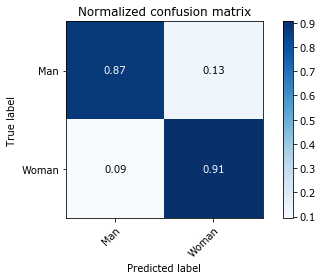

In [78]:
# training
start_time = time.time()
model, scores = train_model(CLASSIFIER, X_train, y_train, X_test, y_test, PARAMS[CLASSIFIER])
print(f'Time to train the classifier: {round((time.time()-start_time)/60, 1)} m')

In [79]:
# metrics
try:
    models_and_scores
except:
    models_and_scores = None
if True: #not isinstance(models_and_scores, pd.DataFrame)
    models_and_scores = pd.DataFrame([np.array([model, scores])], columns=['Model', 'Scores'])
    models_and_scores['Accuracy'] = models_and_scores['Scores'].apply(lambda scores: scores[0])
    models_and_scores['Precision'] = models_and_scores['Scores'].apply(lambda scores: scores[1])
    models_and_scores['Recall'] = models_and_scores['Scores'].apply(lambda scores: scores[2])
    models_and_scores = models_and_scores.drop('Scores', axis='columns')

print('Mean accuracy: {:.3f}'.format(models_and_scores['Accuracy'].mean()))
print('Precision for women tweets : {:.3f}'.format(models_and_scores['Precision'][0][1]))
print('Precision for men tweets : {:.3f}'.format(models_and_scores['Precision'][0][0]))
print('Recall for women tweets : {:.3f}'.format(models_and_scores['Recall'][0][1]))
print('Recall for men tweets : {:.3f}'.format(models_and_scores['Recall'][0][0]))
models_and_scores.head()

Mean accuracy: 0.889
Precision for women tweets : 0.876
Precision for men tweets : 0.903
Recall for women tweets : 0.906
Recall for men tweets : 0.873


,Model,Accuracy,Precision,Recall
0,<catboost.core.CatBoostClassifier object at 0x...,0.889043,"[0.9025787965616046, 0.8763440860215054]","[0.8725761772853186, 0.9055555555555556]"
